# とりあえずNNを回す

In [1]:
import os
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import polars as pl
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
import mlflow
import mlflow.pytorch

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import preprocess_for_all_models as my_preprocess
import word2vec_for_categorical_col as my_word2vec
import preprocess_for_nn as my_nn_preprocess

## 各種定数

In [3]:
RANDOM_STATE = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
TARGET_COLUMN = "ProdTaken"
DROP_COLUMNS = ["id", "MonthlyIncome", "customer_info"]

In [4]:
# 今日の日付を取得し、YYYYMMDD形式にフォーマットする
today_str: str = datetime.now().strftime("%Y%m%d")

# 今日の日付をディレクトリ名として設定
data_directory_name: str = "../data/" + today_str
model_directory_name: str = "../models/" + today_str

# ディレクトリが存在しない場合、作成する
if not os.path.exists(data_directory_name):
    os.makedirs(data_directory_name)
if not os.path.exists(model_directory_name):
    os.makedirs(model_directory_name)


## 前処理

In [5]:
# ローカルファイルを読み込む
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
# google colaboratory で実行する場合は以下を有効にする
# from google.colab import drive
# drive.mount('/content/drive')
# train_df = pd.read_csv("/content/drive/mydrive/signate_cup_2024_data/train.csv")
# test_df = pd.read_csv("/content/drive/mydrive/signate_cup_2024_data/test.csv")

In [6]:
# すべてのモデルに共通する前処理を実施
train_df, test_df = my_preprocess.preprocess_total(train_df, test_df)

In [7]:
# word2vecを使用してカテゴリカル変数をエンベディング
train_df, test_df = my_word2vec.word2vec_for_customer_info(
    train_df,test_df
)

In [8]:
train_df, test_df = my_nn_preprocess.preprocess_data(train_df, test_df)

## 学習用データの設定

In [9]:
X_train = train_df.drop(columns=[TARGET_COLUMN, "id"])  # 入力データ
y_train = train_df[TARGET_COLUMN]  # ターゲット変数

In [10]:
# 検証用データの作成
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

### データローダの設定

In [11]:
# PyTorch用のデータセットを作成
class TrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# データセットの作成
train_dataset = TrainDataset(X_train, y_train)
val_dataset = TrainDataset(X_val, y_val)

# データローダーの作成
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [12]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# モデルのインスタンス化
model = SimpleNN(input_dim=X_train.shape[1])


In [13]:
criterion = nn.BCELoss()  # バイナリクロスエントロピー損失
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
# Early Stoppingのパラメータ
early_stopping_patience = 5  # 悪化が連続する回数
best_val_loss = float("inf")
patience_counter = 0

# モデル保存用のパス
best_model_path = model_directory_name + "/toy_best_model.pth"

# 訓練と検証の損失を格納するリスト
train_losses = []
val_losses = []
train_aucs = []
val_aucs = []

# 学習ループ
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    all_targets_train = []
    all_outputs_train = []    
    all_targets_val = []
    all_outputs_val = []

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # AUC計算のためにターゲットと出力を記録
        all_targets_train.extend(targets.cpu().numpy())
        all_outputs_train.extend(outputs.squeeze().detach().cpu().numpy())

    train_losses.append(running_loss / len(train_loader))

    # AUCを計算
    auc_train = roc_auc_score(all_targets_train, all_outputs_train)
    train_aucs.append(auc_train)

    # 検証フェーズ
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()
    
            # AUC計算のためにターゲットと出力を記録
            all_targets_val.extend(targets.cpu().numpy())
            all_outputs_val.extend(outputs.squeeze().detach().cpu().numpy())

    val_losses.append(val_loss / len(val_loader))


    # AUCを計算
    auc_val = roc_auc_score(all_targets_val, all_outputs_val)
    val_aucs.append(auc_val)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {train_losses[-1]}, Train_AUC: {train_aucs} Validation Loss: {val_losses[-1]}, val_AUC: {auc_val}")

    # Early Stoppingのチェックとモデル保存
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0  # 改善があったのでリセット
        torch.save(model.state_dict(), best_model_path)  # 最善のモデルを保存
    else:
        patience_counter += 1  # 改善がないのでカウントアップ

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        model.load_state_dict(torch.load(best_model_path))  # 最善のモデルをロード
        break

Epoch 1/100, Training Loss: 0.5052300535819747, Train_AUC: [0.5352449112371038] Validation Loss: 0.3839980526403947, val_AUC: 0.5788873400076036
Epoch 2/100, Training Loss: 0.3972336788746444, Train_AUC: [0.5352449112371038, 0.6594076277225268] Validation Loss: 0.3577906949953599, val_AUC: 0.729076524793164
Epoch 3/100, Training Loss: 0.370411597869613, Train_AUC: [0.5352449112371038, 0.6594076277225268, 0.7467980295566502] Validation Loss: 0.3306460136717016, val_AUC: 0.7916251787750964
Epoch 4/100, Training Loss: 0.349150801924142, Train_AUC: [0.5352449112371038, 0.6594076277225268, 0.7467980295566502, 0.7834743005855561] Validation Loss: 0.3092153763229197, val_AUC: 0.8148523634520339
Epoch 5/100, Training Loss: 0.3374207405881448, Train_AUC: [0.5352449112371038, 0.6594076277225268, 0.7467980295566502, 0.7834743005855561, 0.7895209178878665] Validation Loss: 0.3029670173471624, val_AUC: 0.8222025091876822
Epoch 6/100, Training Loss: 0.32993903722275386, Train_AUC: [0.535244911237103

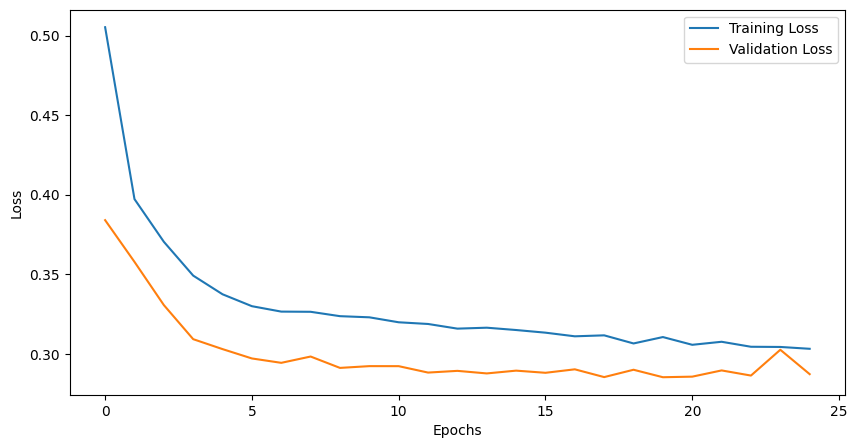

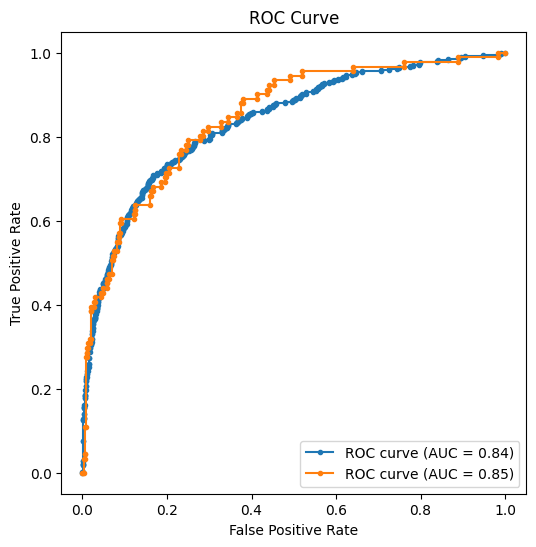

In [15]:
# 損失のグラフ化
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ROC曲線の描画
fpr_train, tpr_train, _ = roc_curve(all_targets_train, all_outputs_train)
fpr_val, tpr_val, _ = roc_curve(all_targets_val, all_outputs_val)
plt.figure(figsize=(6, 6))
plt.plot(fpr_train, tpr_train, marker='.', label=f'ROC curve (AUC = {auc_train:.2f})')
plt.plot(fpr_val, tpr_val, marker='.', label=f'ROC curve (AUC = {auc_val:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [16]:
test_df.head()

,id,CityTier,DurationOfPitch,Occupation,Gender(is_male),NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,...,customer_info_concat_svd_0,customer_info_concat_svd_1,customer_info_concat_svd_2,TypeofContact_Company Invited,TypeofContact_Self Enquiry,TypeofContact_unknown,marriage_history_未婚,marriage_history_独身,marriage_history_結婚済み,marriage_history_離婚済み
0,3489.0,0.5,0.361407,0.5,1.0,0.0,0.666667,1.00,0.0,0.875,...,0.069671,0.146588,0.986741,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,3490.0,0.5,0.333642,0.5,0.0,0.0,0.666667,0.25,0.0,0.500,...,-0.017377,0.044482,0.998859,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3491.0,0.0,0.250347,0.0,0.0,0.0,0.666667,0.00,0.0,0.125,...,-0.000229,-0.112947,-0.993601,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3492.0,0.5,0.194817,0.0,1.0,0.0,0.666667,0.00,0.5,0.125,...,0.018846,0.052346,-0.998451,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3493.0,0.0,0.194817,0.0,1.0,0.0,0.666667,0.00,0.0,0.125,...,-0.018256,0.078343,0.996759,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
# 特徴量として使用するカラムを定義 (NUMERIC_COLUMNSに基づく)
X_test = test_df.drop(columns=["id"])  # "id" カラムを除外して特徴量に

# モデルのインスタンス化と最善モデルの読み込み
model = SimpleNN(input_dim=X_test.shape[1])
model.load_state_dict(torch.load("../models/toy_best_model.pth"))
model.eval()

# テストデータに対して予測を行う
with torch.no_grad():
    test_predictions = model(torch.tensor(X_test.values, dtype=torch.float32))
    test_predictions = test_predictions.squeeze().numpy()

# 結果をデータフレームに変換
submission_df = pd.DataFrame({
    "id": test_df["id"].astype(int),  # "id" カラムを使用
    "prediction": test_predictions
})

# CSVファイルに保存
submission_df.to_csv(data_directory_name + "/submission.csv", index=False, header=None)

FileNotFoundError: [Errno 2] No such file or directory: '../models/toy_best_model.pth'